In [91]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.5.0


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'../imagens'
BATCH_SIZE = 24 * strategy.num_replicas_in_sync
IMAGE_SIZE = [460, 700]
EPOCHS = 25

In [11]:
def montar_nome(path):
    nome_file = []
    file_path = []
    x = 0
    for p, _, files in os.walk(os.path.abspath(path)):
        for file in files:
            nome_file.append(file)
            file_path.append(p+'//'+file)
    return nome_file, file_path

def selecionar_classe(nomes):
    classe = []
    for nome in nomes:
        if re.match(r"TA[0-9].{1,5}", nome) != None:
            classe.append('TA')
        elif re.match(r"DCI[0-9].{1,5}", nome) != None:
            classe.append('DCI')
        elif re.match(r"F[0-9].{1,5}", nome) != None:
            classe.append('F')
        elif re.match(r"PT[0-9].{1,5}", nome) != None:
            classe.append('PT')
        elif re.match(r"DC[0-9].{1,5}", nome) != None:
            classe.append('DC')
        elif re.match(r"LC[0-9].{1,5}", nome) != None:
            classe.append('LC')
        elif re.match(r"MC[0-9].{1,5}", nome) != None:
            classe.append('MC')
        elif re.match(r"PC[0-9].{1,5}", nome) != None:
            classe.append('PC')
        elif 'TA' not in nome:
            classe.append('A')
    return classe

def pegar_tipos(file_path):
    tipo = []
    for path in file_path:
        if 'B' in path:
            tipo.append('B')
        if 'M' in path:
            tipo.append('M')
    return tipo

def pegar_ampliacao(file_path):
    ampliacao = []
    for path in file_path:
        if '40x' in path:
            ampliacao.append('40x')
        elif '100x' in path:
            ampliacao.append('100x')
        elif '200x' in path:
            ampliacao.append('200x')
        elif '400x' in path:
            ampliacao.append('400x')
    return ampliacao

def pegar_origem(file_path):
    origem = []
    for path in file_path:
        if 'treino' in path:
            origem.append('Te')
        elif 'Teste' in path:
            origem.append('Tr')
    return origem

def montar_data_frame(path):
    nome_file, file_path = montar_nome(path)
    classes = selecionar_classe(nome_file)
    tipos = pegar_tipos(file_path)
    ampliacaos = pegar_ampliacao(file_path)
    origem = pegar_origem(file_path)
    data = {'FikePath': file_path, 'Type': tipos, 'classes':classes,'Magnification':ampliacaos, 'DataSet':origem}
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.transpose()
    return df



In [25]:
df_geral =  montar_data_frame(r'C:\Users\rodrigo.cabral\PycharmProjects\TCC-CienciaDados\Imagens')
df_treino = df_geral[df_geral['DataSet'] == 'Tr'][df_geral['Magnification'] == '400x']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Magnification'] == '400x']

<ipython-input-25-a239884d8a0e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treino = df_geral[df_geral['DataSet'] == 'Tr'][df_geral['Magnification'] == '400x']
<ipython-input-25-a239884d8a0e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Magnification'] == '400x']


In [13]:
print(f'quantidade de dados na base de Teste {df_teste.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino.shape[0]}')

quantidade de dados na base de Teste 978
quantidade de dados na base de Treino 786


In [14]:
df_teste.head()

,FikePath,Type,classes,Magnification,DataSet
4102,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Te
4103,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Te
4104,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Te
4105,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Te
4106,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Te


In [16]:
df_teste.classes.value_counts()

DCI    323
DC     244
F       76
LC      67
PT      59
MC      57
TA      56
PC      50
A       46
Name: classes, dtype: int64

In [17]:
df_treino.classes.value_counts()

DC     244
DCI    131
F       76
LC      67
PT      59
MC      57
TA      56
PC      50
A       46
Name: classes, dtype: int64

In [18]:
df_teste['Magnification'].unique()

array(['400x'], dtype=object)

In [19]:
df_teste['DataSet'].unique()

array(['Te'], dtype=object)

In [20]:
df_treino['DataSet'].unique()

array(['Tr'], dtype=object)

In [21]:
df_treino.head()

,FikePath,Type,classes,Magnification,DataSet
3316,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Tr
3317,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Tr
3318,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Tr
3319,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Tr
3320,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,B,A,400x,Tr


Eliminar os dados que não precisam 

In [26]:
df_treino = df_treino.drop(columns=['Magnification','DataSet','Type'])
df_treino.head()

,FikePath,classes
3316,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A
3317,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A
3318,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A
3319,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A
3320,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A


In [27]:
df_teste = df_teste.drop(columns=['Magnification','DataSet','Type'])
df_teste.head()

,FikePath,classes
4102,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A
4103,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A
4104,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A
4105,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A
4106,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A


In [32]:
label = []

dicionario_classes = {'A': 1, 'F':2,'PT':3,'TA':4,'DC':5, 
                     'LC':6,'MC':7,'PC':8,'DCI':9}

for calsse in df_treino['classes']:
    label.append(dicionario_classes.get(calsse))

    
df_treino['label'] = label

In [33]:
df_treino.head()

,FikePath,classes,label
3316,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A,1
3317,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A,1
3318,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A,1
3319,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A,1
3320,C:\Users\rodrigo.cabral\PycharmProjects\TCC-Ci...,A,1


Transformar filePath em imagem

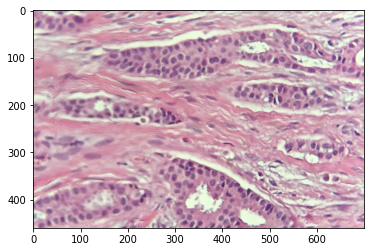

In [34]:
x = np.random.randint(0,df_treino.shape[0]-1)

image = cv2.imread(list(df_treino.FikePath)[x])
imgplot = plt.imshow(image)
plt.show()

In [35]:
X = df_treino['FikePath']
y = df_treino['label']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
x_train.shape

(550,)

In [37]:
x_test.shape

(236,)

Transformando em tensor e tratando a imagem

In [38]:
x_train_tensor = tf.convert_to_tensor(x_train.values, dtype=tf.string)
y_train_tensor = tf.convert_to_tensor(y_train.values)
x_test_tensor = tf.convert_to_tensor(x_test.values, dtype=tf.string)
y_test_tensor = tf.convert_to_tensor(y_test.values)

In [39]:
train_data = tf.data.Dataset.from_tensor_slices((x_train_tensor, y_train_tensor))
test_data = tf.data.Dataset.from_tensor_slices((x_test_tensor, y_test_tensor))


In [40]:
#transformar em imagem

def map_fn(path, label):
    image = tf.image.decode_jpeg(tf.io.read_file(path))

    return image, label

#apply the function
train_data_img = train_data.map(map_fn)
test_data_img = test_data.map(map_fn)

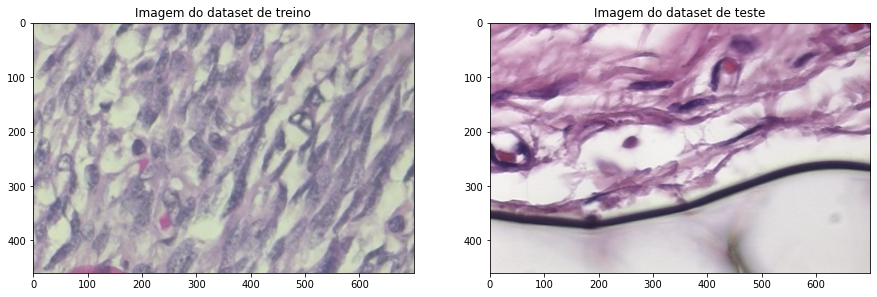

In [41]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data_img.take(1):
    ax[0].set_title('Imagem do dataset de treino');
    ax[0].imshow(i);
for i,l in test_data_img.take(1):
    ax[1].set_title('Imagem do dataset de teste');
    ax[1].imshow(i);

In [42]:
def transformar_cinza(imagem, label):
    img = tf.cast(imagem, tf.float32)
    img = tf.image.rgb_to_grayscale(img)
    return img,label

In [43]:
def normalizar_imagens(imagem, label):
    img = tf.cast(imagem, tf.float32)
    img = (img - 128) / 128
    return img, label

In [44]:
def mudar_tamanho_200_300(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(image, [200,300])
    return img, label

In [45]:
def mudar_tamanho_300_500(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(image, [300,500])
    return img, label

In [46]:
def mudar_tamanho_original(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(image, IMAGE_SIZE)
    return img, label

In [47]:
train_data_tam_200_300 = train_data_img.map(mudar_tamanho_200_300)
test_data_tam_200_300  = test_data_img.map(mudar_tamanho_200_300)

In [48]:
train_data_tam_300_500 = train_data_img.map(mudar_tamanho_300_500)
test_data_tam_300_500  = test_data_img.map(mudar_tamanho_300_500)

In [49]:
train_data_tam = test_data_img.map(mudar_tamanho_original)
test_data_tam = test_data_img.map(mudar_tamanho_original)

In [50]:
train_data_200_300_gray = train_data_tam_200_300.map(transformar_cinza)
test_data_200_300_gray = test_data_tam_200_300.map(transformar_cinza)

In [51]:

train_data_norm__gray_200_300 = train_data_200_300_gray.map(normalizar_imagens)
test_data_norm__gray_200_300 = test_data_200_300_gray.map(normalizar_imagens)

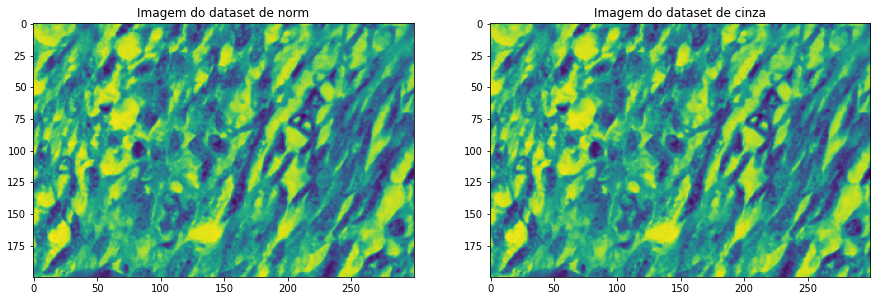

In [52]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data_norm__gray_200_300.take(1):
    ax[0].set_title('Imagem do dataset de norm');
    ax[0].imshow(i);
for i,l in train_data_200_300_gray.take(1):
    ax[1].set_title('Imagem do dataset de cinza');
    ax[1].imshow(i);

In [53]:
train_batches = train_data_norm__gray_200_300.batch(16)
test_batches = test_data_norm__gray_200_300.batch(16)

In [54]:
for i, l in train_batches.take(1):
    print('Train Data Shape',i.shape)
for i, l in test_batches.take(1):
    print('Test Data Shape',i.shape)

Train Data Shape (16, 200, 300, 1)
Test Data Shape (16, 200, 300, 1)


In [82]:
LeNet = models.Sequential()
LeNet.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape =(200,300,1)))
LeNet.add(layers.AveragePooling2D())
LeNet.add(layers.Dense(32, activation='relu'))
LeNet.add(layers.Dense(64, activation='relu'))
LeNet.add(layers.Dropout(0.2))
LeNet.add(layers.Dense(128, activation='relu'))
LeNet.add(layers.BatchNormalization())
LeNet.add(layers.Flatten())
LeNet.add(layers.Dense(128, activation='relu'))
LeNet.add(layers.Dense(64, activation='relu'))
LeNet.add(layers.Dropout(0.2))
LeNet.add(layers.Dense(32, activation='relu'))
LeNet.add(layers.BatchNormalization())
LeNet.add(layers.Dense(10, activation='sigmoid'))
LeNet.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 196, 296, 6)       156       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 98, 148, 6)        0         
_________________________________________________________________
dense_53 (Dense)             (None, 98, 148, 32)       224       
_________________________________________________________________
dense_54 (Dense)             (None, 98, 148, 64)       2112      
_________________________________________________________________
dropout_16 (Dropout)         (None, 98, 148, 64)       0         
_________________________________________________________________
dense_55 (Dense)             (None, 98, 148, 128)      8320      
_________________________________________________________________
batch_normalization_14 (Batc (None, 98, 148, 128)     

In [105]:
LeNet.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [107]:
history = LeNet.fit(train_batches, epochs=100,validation_data=test_batches)

Epoch 1/100
35/35 [==============================] - 72s 2s/step - loss: 1.1850 - accuracy: 0.6455 - val_loss: 2.2508 - val_accuracy: 0.2034
Epoch 2/100
35/35 [==============================] - 70s 2s/step - loss: 0.7371 - accuracy: 0.8309 - val_loss: 2.1596 - val_accuracy: 0.2415
Epoch 3/100
35/35 [==============================] - 68s 2s/step - loss: 0.5343 - accuracy: 0.9000 - val_loss: 2.1859 - val_accuracy: 0.2627
Epoch 4/100
35/35 [==============================] - 77s 2s/step - loss: 0.3388 - accuracy: 0.9436 - val_loss: 2.1615 - val_accuracy: 0.2627
Epoch 5/100
35/35 [==============================] - 67s 2s/step - loss: 0.2176 - accuracy: 0.9782 - val_loss: 2.1206 - val_accuracy: 0.1949
Epoch 6/100
35/35 [==============================] - 69s 2s/step - loss: 0.1569 - accuracy: 0.9945 - val_loss: 2.0705 - val_accuracy: 0.1907
Epoch 7/100
35/35 [==============================] - 70s 2s/step - loss: 0.1676 - accuracy: 0.9836 - val_loss: 2.1123 - val_accuracy: 0.2246
Epoch 8/100
3

Epoch 59/100
35/35 [==============================] - 62s 2s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.0956 - val_accuracy: 0.4534
Epoch 60/100
35/35 [==============================] - 62s 2s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.1072 - val_accuracy: 0.4492
Epoch 61/100
35/35 [==============================] - 60s 2s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.0903 - val_accuracy: 0.4576
Epoch 62/100
35/35 [==============================] - 64s 2s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.3626 - val_accuracy: 0.4492
Epoch 63/100
35/35 [==============================] - 61s 2s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.4557 - val_accuracy: 0.4449
Epoch 64/100
35/35 [==============================] - 61s 2s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.2938 - val_accuracy: 0.4619
Epoch 65/100
35/35 [==============================] - 64s 2s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.3470 - val_accuracy: 0.4534
Epoch 

In [64]:
history

<BatchDataset shapes: ((None, 200, 300, 1), (None,)), types: (tf.float32, tf.int64)>

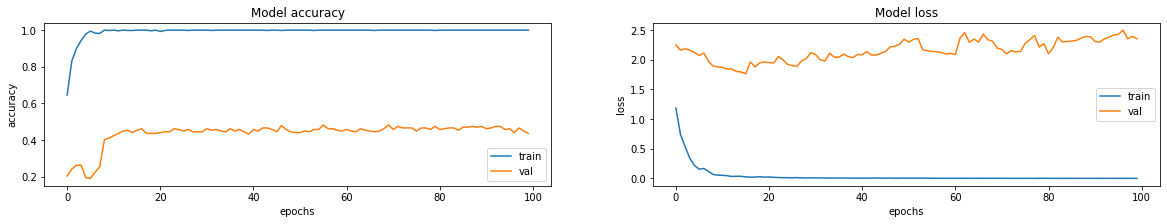

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [116]:
def processar_imagem(path):
    img = tf.image.decode_image(tf.io.read_file(path))
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, [200,300])
    img = tf.image.rgb_to_grayscale(img)
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.expand_dims(img, axis=0)
    return img_tensor

In [117]:
para_pred = processar_imagem(x_test.iloc[5])

In [119]:
prediction = LeNet.predict_classes(para_pred)[0]

In [120]:
prediction

5

In [121]:
x_test.iloc[5]

'C:\\Users\\rodrigo.cabral\\PycharmProjects\\TCC-CienciaDados\\Imagens\\400x_Teste\\B//F6200.png'

In [122]:
x = np.random.randint(0,x_test.shape[0]-1)
para_pred = processar_imagem(x_test.iloc[200])
prediction = LeNet.predict_classes(para_pred)[0]
print(prediction)
print(x_test.iloc[200])

1

'C:\\Users\\rodrigo.cabral\\PycharmProjects\\TCC-CienciaDados\\Imagens\\400x_Teste\\B//A3500.png'